# Predicción de Series Temporales NN - Multivariante
**Importamos librería Keras y Tensorflow**


In [29]:

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('time_series_exb.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2014-01-02,18
2014-01-03,28
2014-01-04,24
2014-01-06,27
2014-01-07,18


# Cargamos datos categóricos: Día y Mes

In [30]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
#df['year']=[x.year for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2014-01-02,18,3,1
2014-01-03,28,4,1
2014-01-04,24,5,1
2014-01-06,27,0,1
2014-01-07,18,1,1


In [31]:
print(len(df['2017']))
print(len(df['2018']))
df.describe()

312
315


,unidades,weekday,month
count,1488.000000,1488.000000,1488.000000
mean,20.010081,2.659274,6.727151
std,11.535998,1.806037,3.456641
min,1.000000,0.000000,1.000000
25%,12.000000,1.000000,4.000000
50%,18.000000,3.000000,7.000000
75%,25.000000,4.000000,10.000000
max,85.000000,6.000000,12.000000


# Reprocesado de los datos

In [0]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [32]:
PASOS=7

# Se Carga Dataset
values = df['unidades'].values

# Se Define tipo Float
values = values.astype('float32')
# Normalizamos
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('unidades',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-10,3.0,1.0,-0.595238,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,...,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4,1,-0.595238
2014-01-11,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,...,-0.333333,3.0,1.0,-0.523810,4.0,1.0,-0.595238,5,1,-0.023810
2014-01-13,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,...,-0.523810,4.0,1.0,-0.595238,5.0,1.0,-0.023810,0,1,-0.428571
2014-01-14,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,...,-0.595238,5.0,1.0,-0.023810,0.0,1.0,-0.428571,1,1,-0.571429
2014-01-15,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4.0,...,-0.023810,0.0,1.0,-0.428571,1.0,1.0,-0.571429,2,1,-0.500000


#Dividimos en set de Entreamiento y Validación

In [33]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(1481, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-10,3.0,1.0,-0.595238,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,...,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,-0.595238
2014-01-11,4.0,1.0,-0.357143,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,...,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4.0,1.0,-0.595238,-0.023810
2014-01-13,5.0,1.0,-0.452381,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,...,3.0,1.0,-0.523810,4.0,1.0,-0.595238,5.0,1.0,-0.023810,-0.428571
2014-01-14,0.0,1.0,-0.380952,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,...,4.0,1.0,-0.595238,5.0,1.0,-0.023810,0.0,1.0,-0.428571,-0.571429
2014-01-15,1.0,1.0,-0.595238,2.0,1.0,-0.333333,3.0,1.0,-0.523810,4.0,...,5.0,1.0,-0.023810,0.0,1.0,-0.428571,1.0,1.0,-0.571429,-0.500000


In [34]:
# split into train and test sets
values = newReframed.values
n_train_days = 1488 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1451, 1, 21) (1451,) (30, 1, 21) (30,)


#Creamos el Modelo de Red Neuronal
**Utilizaremos una Red Feedforward**

In [0]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

**Etrenamos nuestra máquina**

In [36]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Train on 1451 samples, validate on 30 samples
Epoch 1/40
1451/1451 [==============================] - 0s 251us/step - loss: 0.2758 - mean_squared_error: 0.1413 - val_loss: 0.2607 - val_mean_squared_error: 0.1106
Epoch 2/40
1451/1451 [==============================] - 0s 131us/step - loss: 0.1982 - mean_squared_error: 0.0796 - val_loss: 0.2403 - val_mean_squared_error: 0.0923
Epoch 3/40
1451/1451 [========

**Visualizamos Resultados**

30


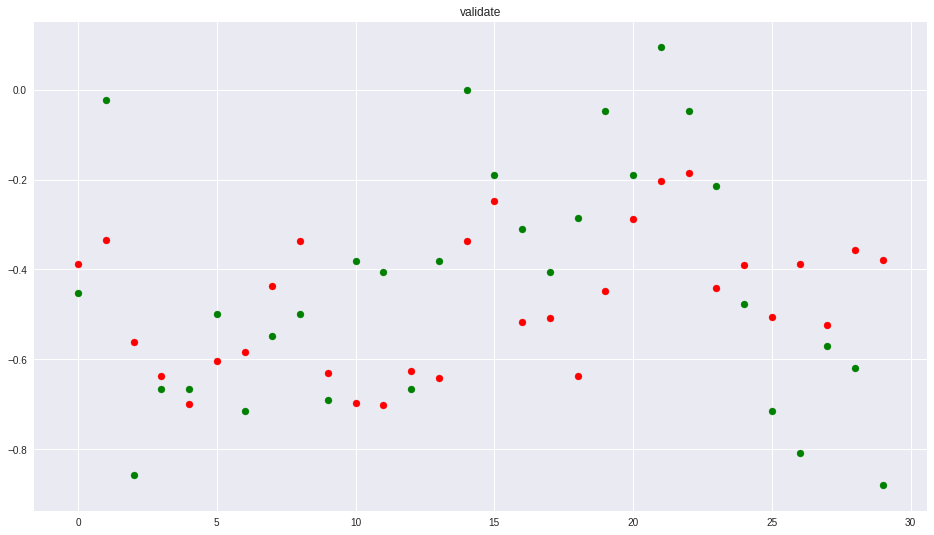

In [37]:

results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

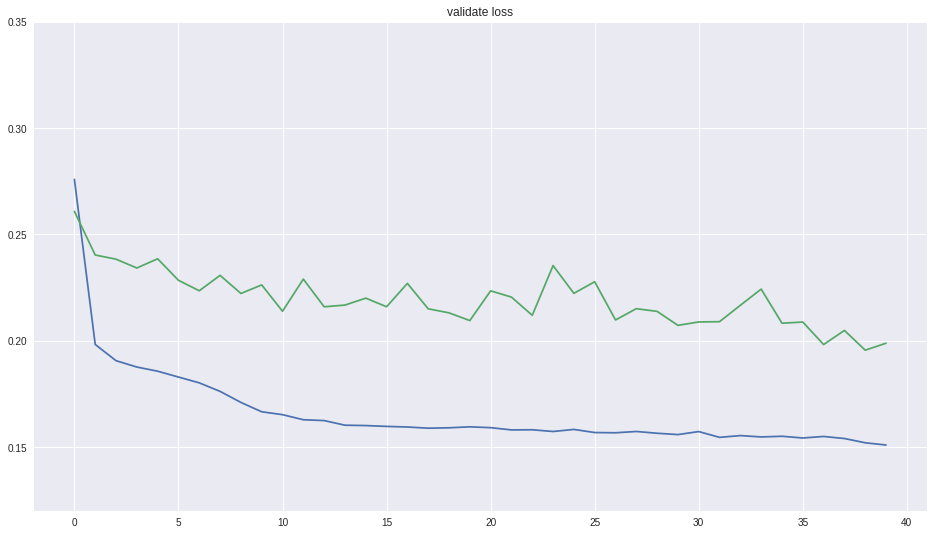

In [38]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

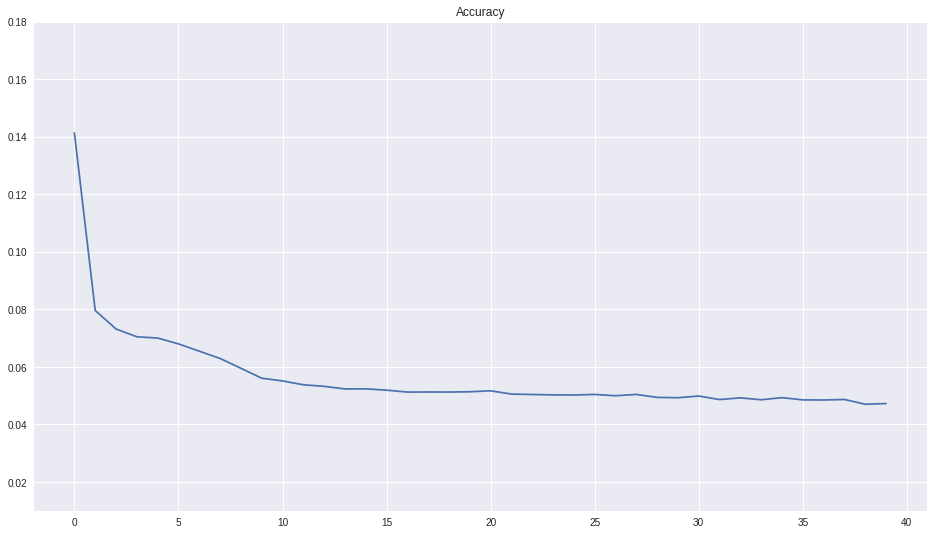

In [39]:

plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [40]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,24.000001,26.673596,-2.673596
1,41.999999,28.942120,13.057879
2,7.000001,19.373889,-12.373889
3,15.000000,16.270543,-1.270543
4,15.000000,13.604387,1.395613
5,22.000001,17.604024,4.395977
6,13.000000,18.503001,-5.503001
7,19.999998,24.667432,-4.667434
8,22.000001,28.899669,-6.899668
9,14.000001,16.470156,-2.470155


In [41]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,24.633333,23.075086,1.558247
std,11.378999,6.402151,10.026553
min,6.000000,13.540501,-21.084601
25%,15.000000,16.949665,-4.393580
50%,23.500000,22.994192,1.876754
75%,33.250000,27.812037,10.632707
max,47.000000,35.195250,16.801916


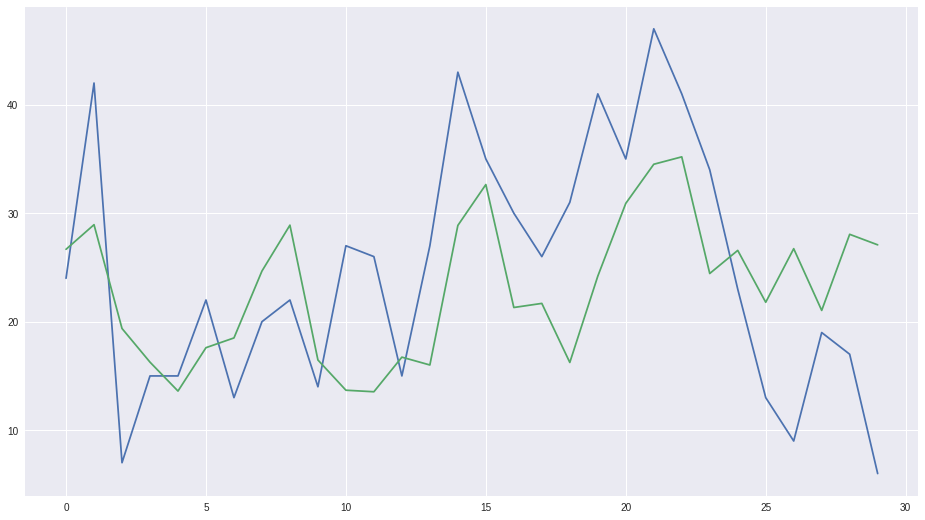

In [42]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico
A partir de la última mes de enero 2018, intentaremos predecir la primer semana de enero 2019.

In [58]:
ultimosDias = df['2018-01-01':'2018-01-31']
ultimosDias

,unidades,weekday,month,scaled
fecha,,,,
2018-01-02,27,1,1,-0.380952
2018-01-03,24,2,1,-0.452381
2018-01-04,15,3,1,-0.666667
2018-01-05,11,4,1,-0.761905
2018-01-06,14,5,1,-0.690476
2018-01-08,11,0,1,-0.761905
2018-01-09,16,1,1,-0.642857
2018-01-10,16,2,1,-0.642857
2018-01-11,16,3,1,-0.642857


# Preparamos los datos para el TEST

In [59]:
scaledMerge=ultimosDias.drop('unidades',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 1.          1.         -0.38095242]
 [ 2.          1.         -0.45238096]
 [ 3.          1.         -0.66666669]
 [ 4.          1.         -0.76190478]
 [ 5.          1.         -0.69047618]
 [ 0.          1.         -0.76190478]
 [ 1.          1.         -0.64285719]
 [ 2.          1.         -0.64285719]
 [ 3.          1.         -0.64285719]
 [ 4.          1.         -0.69047618]
 [ 5.          1.         -0.52380955]
 [ 0.          1.         -0.14285713]
 [ 1.          1.         -0.21428573]
 [ 2.          1.         -0.45238096]
 [ 3.          1.         -0.59523809]
 [ 4.          1.         -0.52380955]
 [ 5.          1.         -0.61904764]
 [ 6.          1.         -0.73809528]
 [ 0.          1.         -0.52380955]
 [ 1.          1.         -0.5714286 ]
 [ 2.          1.         -0.66666669]
 [ 3.          1.         -0.5714286 ]
 [ 4.          1.         -0.69047618]
 [ 5.          1.         -0.33333337]
 [ 0.          1.         -0.45238096]
 [ 1.          1.        

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-10,1.0,1.0,-0.380952,2.0,1.0,-0.452381,3.0,1.0,-0.666667,4.0,...,-0.761905,5.0,1.0,-0.690476,0.0,1.0,-0.761905,1.0,1.0,-0.642857
2018-01-11,2.0,1.0,-0.452381,3.0,1.0,-0.666667,4.0,1.0,-0.761905,5.0,...,-0.690476,0.0,1.0,-0.761905,1.0,1.0,-0.642857,2.0,1.0,-0.642857
2018-01-12,3.0,1.0,-0.666667,4.0,1.0,-0.761905,5.0,1.0,-0.690476,0.0,...,-0.761905,1.0,1.0,-0.642857,2.0,1.0,-0.642857,3.0,1.0,-0.642857
2018-01-13,4.0,1.0,-0.761905,5.0,1.0,-0.690476,0.0,1.0,-0.761905,1.0,...,-0.642857,2.0,1.0,-0.642857,3.0,1.0,-0.642857,4.0,1.0,-0.690476
2018-01-15,5.0,1.0,-0.690476,0.0,1.0,-0.761905,1.0,1.0,-0.642857,2.0,...,-0.642857,3.0,1.0,-0.642857,4.0,1.0,-0.690476,5.0,1.0,-0.523810
2018-01-16,0.0,1.0,-0.761905,1.0,1.0,-0.642857,2.0,1.0,-0.642857,3.0,...,-0.642857,4.0,1.0,-0.690476,5.0,1.0,-0.523810,0.0,1.0,-0.142857
2018-01-17,1.0,1.0,-0.642857,2.0,1.0,-0.642857,3.0,1.0,-0.642857,4.0,...,-0.690476,5.0,1.0,-0.523810,0.0,1.0,-0.142857,1.0,1.0,-0.214286


In [60]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(14, 1, 21)
[[[ 1.          1.         -0.64285719  2.          1.
   -0.64285719  3.          1.         -0.64285719  4.
    1.         -0.69047618  5.          1.         -0.52380955
    0.          1.         -0.14285713  1.          1.
   -0.21428573]]

 [[ 2.          1.         -0.64285719  3.          1.
   -0.64285719  4.          1.         -0.69047618  5.
    1.         -0.52380955  0.          1.         -0.14285713
    1.          1.         -0.21428573  2.          1.
   -0.45238096]]

 [[ 3.          1.         -0.64285719  4.          1.
   -0.69047618  5.          1.         -0.52380955  0.
    1.         -0.14285713  1.          1.         -0.21428573
    2.          1.         -0.45238096  3.          1.
   -0.59523809]]

 [[ 4.          1.         -0.69047618  5.          1.
   -0.52380955  0.          1.         -0.14285713  1.
    1.         -0.21428573  2.          1.         -0.45238096
    3.          1.         -0.59523809  4.          1.
   -0.52380955]]

 [[ 

In [0]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

# Pronóstico para la "próximo mes"

In [62]:
results=[]
for i in range(31):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 1.          1.         -0.64285719  2.          1.
   -0.64285719  3.          1.         -0.64285719  4.
    1.         -0.69047618  5.          1.         -0.52380955
    0.          1.         -0.14285713  1.          1.
   -0.21428573]]

 [[ 2.          1.         -0.64285719  3.          1.
   -0.64285719  4.          1.         -0.69047618  5.
    1.         -0.52380955  0.          1.         -0.14285713
    1.          1.         -0.21428573  2.          1.
   -0.45238096]]

 [[ 3.          1.         -0.64285719  4.          1.
   -0.69047618  5.          1.         -0.52380955  0.
    1.         -0.14285713  1.          1.         -0.21428573
    2.          1.         -0.45238096  3.          1.
   -0.59523809]]

 [[ 4.          1.         -0.69047618  5.          1.
   -0.52380955  0.          1.         -0.14285713  1.
    1.         -0.21428573  2.          1.         -0.45238096
    3.          1.         -0.59523809  4.          1.
   -0.52380955]]

 [[ 5.   

# Re-Convertimos los resultados

In [63]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.60117775], dtype=float32), array([-0.66307646], dtype=float32), array([-0.3890187], dtype=float32), array([-0.7976796], dtype=float32), array([-0.5285586], dtype=float32), array([-0.10350522], dtype=float32), array([-0.3715723], dtype=float32), array([-0.55862105], dtype=float32), array([-0.32987007], dtype=float32), array([-0.26594982], dtype=float32), array([-0.5266276], dtype=float32), array([-0.54790354], dtype=float32), array([-0.6788889], dtype=float32), array([-0.6045186], dtype=float32), array([-0.6116229], dtype=float32), array([-0.36549658], dtype=float32), array([-0.2953418], dtype=float32), array([-0.5844823], dtype=float32), array([-0.6382816], dtype=float32), array([-0.6980566], dtype=float32), array([-0.63188994], dtype=float32), array([-0.6481751], dtype=float32), array([-0.3934903], dtype=float32), array([-0.31276593], dtype=float32), array([-0.60270643], dtype=float32), array([-0.6557925], dtype=float32), array([-0.7016402], dtype=float32), array([-0.641386

array([[17.75053528],
       [15.15078957],
       [26.66121469],
       [ 9.49745768],
       [20.80053911],
       [38.65278138],
       [27.39396467],
       [19.53791677],
       [29.1454575 ],
       [31.83010835],
       [20.8816416 ],
       [19.98805223],
       [14.48666641],
       [17.61021999],
       [17.31183783],
       [27.64914449],
       [30.59564545],
       [18.45174374],
       [16.19217437],
       [13.68162463],
       [16.46062343],
       [15.77664584],
       [26.47340749],
       [29.86383174],
       [17.6863307 ],
       [15.45671696],
       [13.53111301],
       [16.06177002],
       [15.2482167 ],
       [26.07651298],
       [29.63688396]])

# Visualizamos el prónostico

,pronostico
0,17.750535
1,15.150790
2,26.661215
3,9.497458
4,20.800539
5,38.652781
6,27.393965
7,19.537917
8,29.145457
9,31.830108


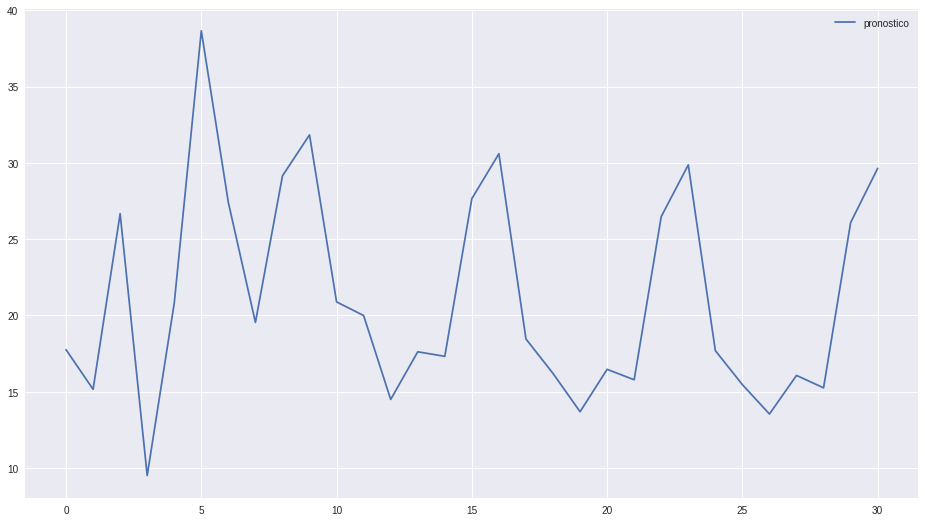

In [64]:
prediccionEnero2019 = pd.DataFrame(inverted)
prediccionEnero2019.columns = ['pronostico']
prediccionEnero2019.plot()
prediccionEnero2019.to_csv('pronostico_multivariate.csv')
prediccionEnero2019

In [65]:
prediccionEnero2019

,pronostico
0,17.750535
1,15.150790
2,26.661215
3,9.497458
4,20.800539
5,38.652781
6,27.393965
7,19.537917
8,29.145457
9,31.830108
